# DataVerse Bean & Brew Analysis


In [19]:
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install scikit-learn
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.1 MB/s eta 0:00:00


## Data Cleaning and Wrangling


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
items = pd.read_csv('items.csv') # The menu
before = pd.read_csv('before_surcharge.csv') # Data from before surcharge is applied.
surcharge = pd.read_csv('surcharge.csv') # Data from the point where surcharge is applied on November 1st.
# Load files you uploaded
sales = pd.read_csv("sales.csv")
# Merge on the item name
merged = sales.merge(items, on="item_name", how="left")

print(merged.head())


         date      time    item_name transaction_type own_cup  surcharge  \
0  2022-01-01  07:03:30    Cold Brew          Takeout    True      False   
1  2022-01-01  07:30:58  Iced Coffee          Takeout    True      False   
2  2022-01-01  08:32:23   Iced Latte          Takeout   False      False   
3  2022-01-01  08:45:03        Latte          Dine-in    True      False   
4  2022-01-01  09:03:47        Latte          Takeout   False      False   

   customer_id  price  production_cost item_type drink_temperature drink_type  
0        26946   4.75             1.35     Drink              Cold     Coffee  
1        24356   4.00             1.10     Drink              Cold     Coffee  
2         3760   4.60             1.25     Drink              Cold     Coffee  
3         5900   4.50             1.20     Drink               Hot     Coffee  
4        11589   4.50             1.20     Drink               Hot     Coffee  


Data cleaning and preparation allowed us to conduct a deeper analysis by:

- Splitting the dataset into pre-surcharge and post-surcharge time periods.

- Merging the sales and items tables into a single unified dataset.

This made the data more readable and easier to query by:

- Adding each product’s price, production cost, and true charged price, which enabled straightforward profit calculations.

- Incorporating item attributes such as drink temperature, item type, and drink type.

- Transforming time information into useful features such as the hour of purchase.

- Producing a single consolidated dataset suitable for training predictive models.

This preparation ensured the dataset was consistent, complete, and usable for reliable analysis, modeling, and policy evaluation.

## Exploratory Data Analysis

In [59]:
# =============================================================
# BEFORE SURCHARGE — add merch flag
# =============================================================
before_m["is_merch"] = before_m["item_type"].str.contains("merch", case=False, na=False)

before_monthly_split = before_m.groupby("month").agg(
    merch_sales=("is_merch", lambda x: x.sum()),
    reusable_sales=("own_cup", 
                    lambda x: ((x == True) & (~before_m.loc[x.index, "is_merch"])).sum()),
    non_reusable_sales=("own_cup", 
                        lambda x: ((x == False) & (~before_m.loc[x.index, "is_merch"])).sum()),

    merch_profit=("profit", 
                  lambda p: p[before_m.loc[p.index, "is_merch"]].sum()),
    reusable_profit=("profit", 
                     lambda p: p[(before_m.loc[p.index, "own_cup"] == True) & 
                                 (~before_m.loc[p.index, "is_merch"])].sum()),
    non_reusable_profit=("profit", 
                         lambda p: p[(before_m.loc[p.index, "own_cup"] == False) & 
                                     (~before_m.loc[p.index, "is_merch"])].sum())
).reset_index()

print("\n=== BEFORE SURCHARGE — Monthly Merch / Reusable / Non-Reusable ===")
print(before_monthly_split)


# =============================================================
# AFTER SURCHARGE — add merch flag
# =============================================================
surcharge_m["is_merch"] = surcharge_m["item_type"].str.contains("merch", case=False, na=False)

after_monthly_split = surcharge_m.groupby("month").agg(
    merch_sales=("is_merch", lambda x: x.sum()),
    reusable_sales=("own_cup", 
                    lambda x: ((x == True) & (~surcharge_m.loc[x.index, "is_merch"])).sum()),
    non_reusable_sales=("own_cup", 
                        lambda x: ((x == False) & (~surcharge_m.loc[x.index, "is_merch"])).sum()),

    merch_profit=("profit", 
                  lambda p: p[surcharge_m.loc[p.index, "is_merch"]].sum()),
    reusable_profit=("profit", 
                     lambda p: p[(surcharge_m.loc[p.index, "own_cup"] == True) & 
                                 (~surcharge_m.loc[p.index, "is_merch"])].sum()),
    non_reusable_profit=("profit", 
                         lambda p: p[(surcharge_m.loc[p.index, "own_cup"] == False) & 
                                     (~surcharge_m.loc[p.index, "is_merch"])].sum())
).reset_index()

print("\n=== AFTER SURCHARGE — Monthly Merch / Reusable / Non-Reusable ===")
print(after_monthly_split)




=== BEFORE SURCHARGE — Monthly Merch / Reusable / Non-Reusable ===
      month  merch_sales  reusable_sales  non_reusable_sales  merch_profit  \
0   2022-01           36             335                 468         332.0   
1   2022-02           40             318                 442         363.0   
2   2022-03           40             389                 578         356.0   
3   2022-04           41             329                 526         379.0   
4   2022-05           43             371                 494         385.0   
5   2022-06           52             352                 528         477.0   
6   2022-07           50             345                 552         454.0   
7   2022-08           40             348                 520         360.0   
8   2022-09           40             228                 405         364.0   
9   2022-10           21             233                 361         189.0   
10  2022-11           30             244                 342         276.0

Reusable-cup usage stayed strong even after the surcharge.

Non-reusable sales did not drop — demand remained stable.

Total drink sales increased slightly after the surcharge.

Profits rose across reusable, non-reusable, and merch categories.

The surcharge did not harm customer behavior or sales volume.

Overall: surcharge improved revenue while maintaining customer adoption.

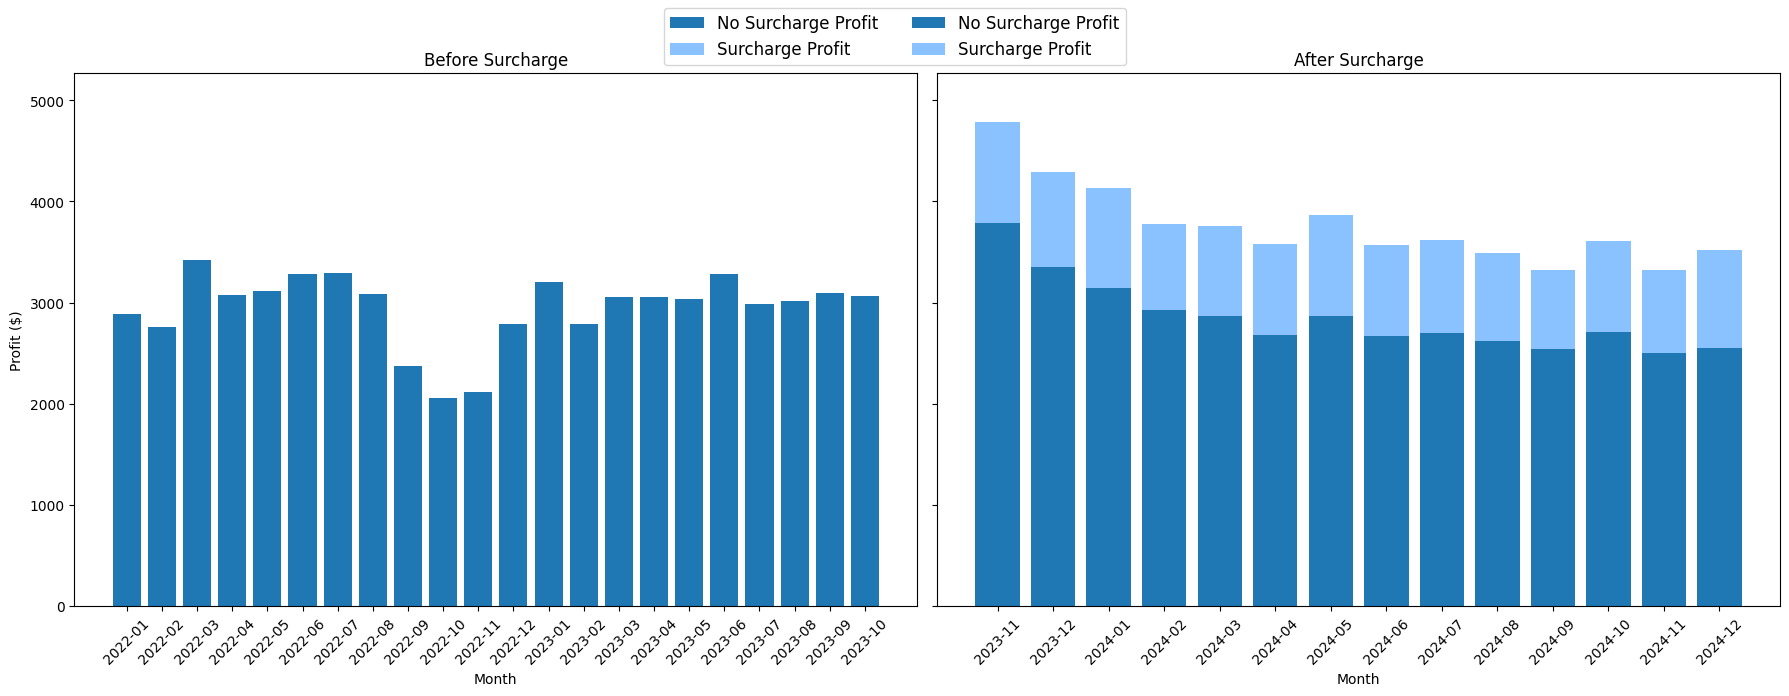

In [61]:
# ------------------------------------------------------
# Load datasets
# ------------------------------------------------------
items = pd.read_csv('items.csv')
before = pd.read_csv('before_surcharge.csv')
after = pd.read_csv('surcharge.csv')

before["date"] = pd.to_datetime(before["date"])
after["date"] = pd.to_datetime(after["date"])

# ------------------------------------------------------
# BEFORE — merge + profit
# ------------------------------------------------------
before_m = (
    before.merge(items, on="item_name")
          .assign(
              surcharge_amount=0,
              profit=lambda df: df["price"] - df["production_cost"],
              month=lambda df: df["date"].dt.to_period("M").astype(str)
          )
)

pivoted_before = (
    before_m.groupby(["month", "surcharge"])["profit"]
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

if True not in pivoted_before.columns:
    pivoted_before[True] = 0


# ------------------------------------------------------
# AFTER — merge + profit
# ------------------------------------------------------
after_m = (
    after.merge(items, on="item_name")
         .assign(
             surcharge_amount=lambda df: df["surcharge"].astype(int) * 0.50,
             profit=lambda df: df["price"] + df["surcharge_amount"] - df["production_cost"],
             month=lambda df: df["date"].dt.to_period("M").astype(str)
         )
)

monthly_after = (
    after_m.groupby(["month", "surcharge"])["profit"]
    .sum()
    .reset_index()
)

pivoted_after = (
    monthly_after.pivot(index="month", columns="surcharge", values="profit")
    .fillna(0)
    .sort_index()
)

if False not in pivoted_after.columns:
    pivoted_after[False] = 0
if True not in pivoted_after.columns:
    pivoted_after[True] = 0


# ------------------------------------------------------
# SHARED Y-AXIS LIMIT
# ------------------------------------------------------
ymax = max(pivoted_before.sum(axis=1).max(),
           pivoted_after.sum(axis=1).max()) * 1.1


# ------------------------------------------------------
# SIDE-BY-SIDE PLOTS
# ------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# ------------------------------------------------------
# LEFT: BEFORE
# ------------------------------------------------------
axes[0].bar(pivoted_before.index, pivoted_before[False],
            label="No Surcharge Profit",
            color="#1f77b4")  # blue

axes[0].bar(pivoted_before.index, pivoted_before[True],
            bottom=pivoted_before[False],
            label="Surcharge Profit",
            color="#89c2ff")  # light blue

axes[0].set_title("Before Surcharge")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Profit ($)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, ymax)


# ------------------------------------------------------
# RIGHT: AFTER
# ------------------------------------------------------
axes[1].bar(pivoted_after.index, pivoted_after[False],
            label="No Surcharge Profit",
            color="#1f77b4")  # blue

axes[1].bar(pivoted_after.index, pivoted_after[True],
            bottom=pivoted_after[False],
            label="Surcharge Profit",
            color="#89c2ff")  # light blue

axes[1].set_title("After Surcharge")
axes[1].set_xlabel("Month")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, ymax)


# ------------------------------------------------------
# SHARED LEGEND
# ------------------------------------------------------
fig.legend(loc="upper center", ncol=2, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



The plot above shows how an added $0.50 surcharge did not decrease the monthly profit. However it could result in an increase in profit along with more consumers being attracted to the store.

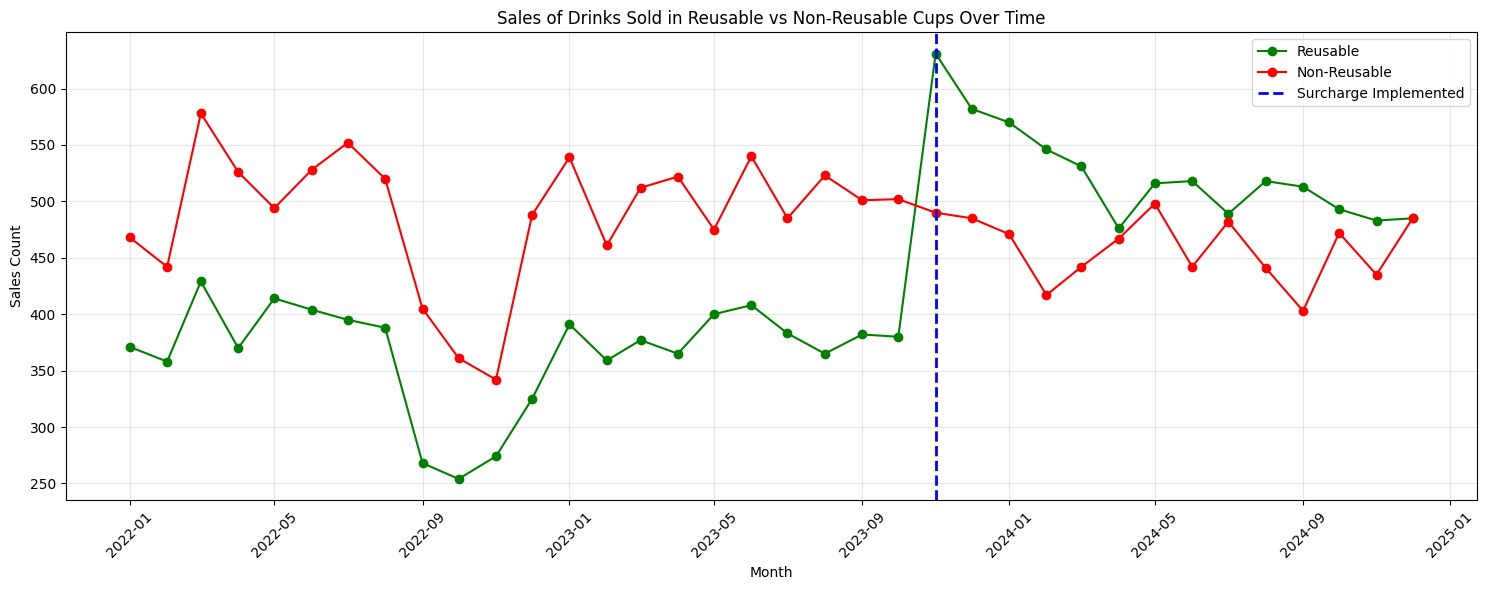

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. Prepare BEFORE dataset
# ----------------------------------------------------
before_drink = before_m.copy()

# classify reusable / non-reusable
before_drink["reusable_sale"] = before_drink["own_cup"].astype(bool)
before_drink["non_reusable_sale"] = ~before_drink["reusable_sale"]

before_monthly = before_drink.groupby("month").agg(
    reusable_sales=("reusable_sale", lambda x: x.sum()),
    non_reusable_sales=("non_reusable_sale", lambda x: x.sum())
).reset_index()

before_monthly["period"] = "before"


# ----------------------------------------------------
# 2. Prepare AFTER dataset
# ----------------------------------------------------
after_drink = surcharge_m.copy()

after_drink["reusable_sale"] = after_drink["own_cup"].astype(bool)
after_drink["non_reusable_sale"] = ~after_drink["reusable_sale"]

after_monthly = after_drink.groupby("month").agg(
    reusable_sales=("reusable_sale", lambda x: x.sum()),
    non_reusable_sales=("non_reusable_sale", lambda x: x.sum())
).reset_index()

after_monthly["period"] = "after"


# ----------------------------------------------------
# 3. Combine into one continuous timeline
# ----------------------------------------------------
combined = pd.concat([before_monthly, after_monthly], ignore_index=True)

# Convert month → timestamp for plotting
combined["month_dt"] = combined["month"].apply(lambda x: pd.Period(x, freq="M").to_timestamp())
combined = combined.sort_values("month_dt")

# surcharge implementation date
surcharge_start = after_monthly["month"].iloc[0]
surcharge_start_dt = pd.Period(surcharge_start, freq="M").to_timestamp()


# ----------------------------------------------------
# 4. Plot line chart
# ----------------------------------------------------
plt.figure(figsize=(15,6))

plt.plot(
    combined["month_dt"],
    combined["reusable_sales"],
    marker="o",
    label="Reusable",
    color="green"
)

plt.plot(
    combined["month_dt"],
    combined["non_reusable_sales"],
    marker="o",
    label="Non-Reusable",
    color="red"
)

# vertical line where surcharge begins
plt.axvline(
    surcharge_start_dt,
    color="blue",
    linestyle="--",
    linewidth=2,
    label="Surcharge Implemented"
)

plt.title("Sales of Drinks Sold in Reusable vs Non-Reusable Cups Over Time")
plt.xlabel("Month")
plt.ylabel("Sales Count")
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



As you can see, a $0.50 surcharge increased the number of drinks sold in reusable cups. However there is a negative trend towards the end of the graph.

**Logistic Regression Model**

We built a logistic regression model to predict whether a customer uses a reusable cup.


- The model helps us understand which factors influence if a customer uses a reusable cup (item_type, hour, price, item_name temperature, transaction_type, drink_temperature).

- It identifies which customer groups are most likely to adopt our returnable-cup program.

- Adding price allows us to test how customer behavior might change under a future surcharge or a cup deposit system.

Overall, the model gives a clear, data-driven foundation for designing and evaluating the returnable-cup initiative.

In [36]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# ======================================================
# 1. LOAD & PREPARE DATA
# ======================================================
df = pd.read_csv("surcharge.csv")
items = pd.read_csv("items.csv")

df = df.merge(items, on="item_name", how="left")

df["date"] = pd.to_datetime(df["date"] + " " + df["time"])
df["hour"] = df["date"].dt.hour

df["own_cup"] = (
    df["own_cup"].astype(str).str.lower().map({"true": 1, "false": 0, "1": 1, "0": 0})
).fillna(0).astype(int)

# ======================================================
# 2. FIX: COMPUTE TRUE ORIGINAL PRICE (base + 0.50 surcharge)
# ======================================================
df["price_original"] = df["price"] + df["surcharge"].astype(int) * 0.50

# ======================================================
# 3. FEATURES + MODEL PIPELINE
# ======================================================
feature_cols = ["hour", "transaction_type", "item_type",
                "drink_type", "drink_temperature", "price_original"]

X = df[feature_cols]
y = df["own_cup"]

cat_cols = ["transaction_type", "item_type", "drink_type", "drink_temperature"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", ["hour", "price_original"])
])

model = Pipeline([
    ("prep", preprocess),
    ("logreg", LogisticRegression(max_iter=2000))
])

model.fit(X, y)

# ======================================================
# 4. ACCURACY
# ======================================================
y_pred_train = model.predict(X)
print("\nModel Accuracy:", accuracy_score(y, y_pred_train))

# ======================================================
# 5. BEFORE (actual historical prices)
# ======================================================
df_before = df.drop(columns=["own_cup"]).copy()
prop_before = pd.Series(model.predict(df_before[feature_cols])).value_counts(normalize=True)

print("\n=== Proportions BEFORE ($0.50 surcharge) ===")
print(prop_before)

# ======================================================
# 6. AFTER: simulate NEW surcharge = $0.85
# ======================================================

df_after = df_before.copy()
df_after["price_original"] = df_after["price"] + df_after["surcharge"].astype(int) * 0.85

prop_after = pd.Series(model.predict(df_after[feature_cols])).value_counts(normalize=True)

print("\n=== Proportions AFTER ($0.85 surcharge simulated) ===")
print(prop_after)




Model Accuracy: 0.727305710761193

=== Proportions BEFORE ($0.50 surcharge) ===
0    0.603802
1    0.396198
Name: proportion, dtype: float64

=== Proportions AFTER ($0.85 surcharge simulated) ===
0    0.62695
1    0.37305
Name: proportion, dtype: float64


Our model predicts that our solution promotes sustainability because it shows that a price surcharge increase of $0.35 encourages customers to use reusable bottles.

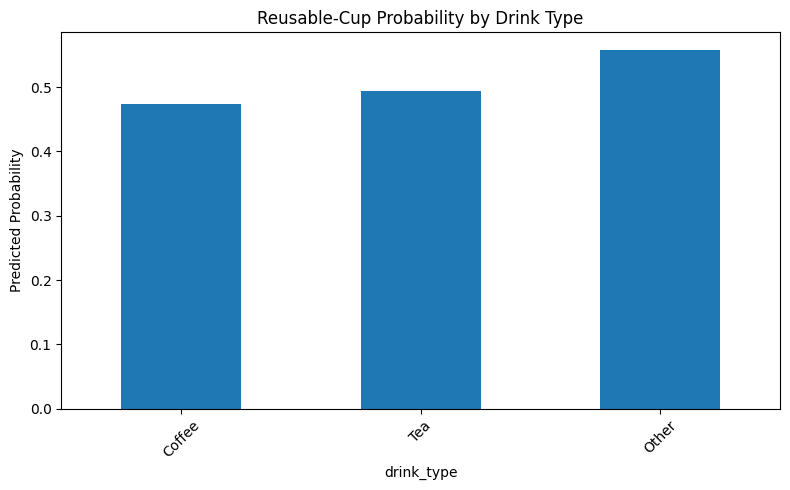

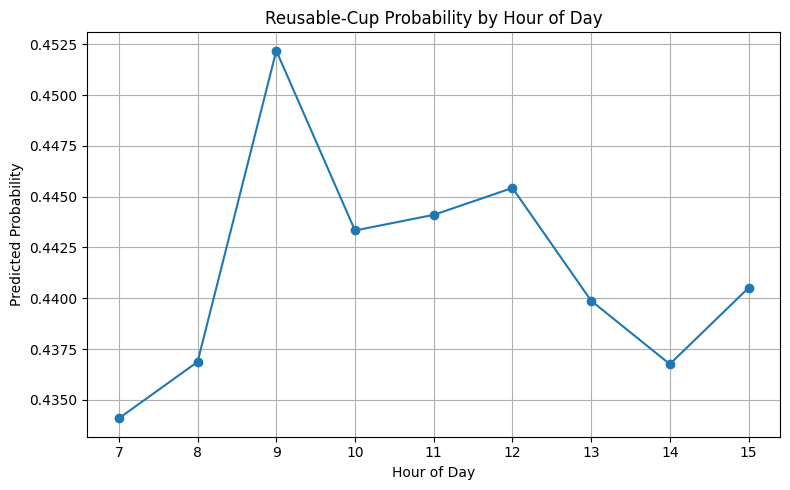

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load prediction file
df = pd.read_csv("surcharge_predictions.csv")

# ------------------------------------------------------
# Plot 1: Reusable-cup probability by drink type
# ------------------------------------------------------
plt.figure(figsize=(8,5))
df.groupby("drink_type")["predicted_prob"].mean().sort_values().plot(kind="bar")
plt.title("Reusable-Cup Probability by Drink Type")
plt.ylabel("Predicted Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------------------------------
# Plot 2: Reusable-cup probability by hour
# ------------------------------------------------------
plt.figure(figsize=(8,5))
df.groupby("hour")["predicted_prob"].mean().plot(kind="line", marker="o")
plt.title("Reusable-Cup Probability by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

Our model shows that most customers use a reusable cup at 9 A.M, and least at 7 A.M.

It also shows that Coffee and Tea consumers are more likely to use reusable cups.

## Sensitivity Analysis


In [39]:
items = pd.read_csv("items.csv")
sales = pd.read_csv("sales.csv")
sales.info()      # column types + summary
sales.describe()  # quick stats (numeric columns)

merged_data = pd.merge(
    sales,      # transaction-level
    items,      # item-level
    on="item_name",  # join key
    how="left"       # keep all sales rows
)

merged_data.to_csv("merged_data.csv", index=False)

merged_data.head(5)

df['date'] = pd.to_datetime(df['date'])
post_policy = df[
    (df['date'] >= '2023-11-01') &
    (df['item_type'] == 'Drink') &
    (df['transaction_type'] == 'Takeout')
].copy()


post_policy.head(5)

print("\n")

current_rate = 1 - post_policy['own_cup'].mean()

current_surcharge_rev = post_policy['surcharge'].sum() * 0.50
post_policy['profit'] = post_policy['price'] - post_policy['production_cost']
current_profit = post_policy['profit'].sum() + current_surcharge_rev

print("Rate" , current_rate, "\n")
print("surcharge revenue ",current_surcharge_rev)

for change in [0.00, 0.10, 0.20, 0.30]:
    adjusted_disposable = post_policy.shape[0] * (current_rate * (1 - change))
    surcharge_rev = adjusted_disposable * 0.85
    print("Behaviour change: ", change, ", Surchage revenue: " , surcharge_rev)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32605 entries, 0 to 32604
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              32605 non-null  object
 1   time              32605 non-null  object
 2   item_name         32605 non-null  object
 3   transaction_type  32605 non-null  object
 4   own_cup           30461 non-null  object
 5   surcharge         32605 non-null  bool  
 6   customer_id       32605 non-null  int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 1.5+ MB


Rate 0.46441544463877305 

surcharge revenue  1726.0
Behaviour change:  0.0 , Surchage revenue:  2934.2
Behaviour change:  0.1 , Surchage revenue:  2640.78
Behaviour change:  0.2 , Surchage revenue:  2347.3599999999997
Behaviour change:  0.3 , Surchage revenue:  2053.94


Increasing surcharge increases revenue if customers don't change their behaviours, but if they start bringing their own reusable cups, surcharge revenue decreases. While more sustainable, it becomes less financially profitable. In past, we've seen that fewer purchases were made 

In [40]:
2934.2-1726

1208.1999999999998

**Running regression analysis for scenario testing**

In [42]:
surcharge_rev = post_policy['surcharge'].sum()* 0.85
drink_rev = post_policy['price'].sum()
total_rev = surcharge_rev + drink_rev

print(total_rev)
print("surcharge", surcharge_rev)

35128.2
surcharge 2934.2


In [43]:
total_profit = (post_policy['price'] - post_policy['production_cost']).sum() + surcharge_rev
lift = total_profit - current_profit
print(lift)

1208.2000000000007


In [44]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M').astype(str)

drinks = df[df['item_type'] == 'Drink'].copy()
baseline = drinks[drinks['date'] >= '2023-11-01']

baseline_monthly = baseline.groupby('month').agg(
    total_drinks=('item_name', 'count'),
    reusable=('own_cup', lambda x: x.eq(True).sum()),
    disposable=('own_cup', lambda x: x.eq(False).sum()),
    surcharge_items=('surcharge', lambda x: x.eq(True).sum())
).reset_index()

baseline_monthly['reusable_rate'] = baseline_monthly['reusable'] / baseline_monthly['total_drinks']
baseline_monthly['disposable_rate'] = baseline_monthly['disposable'] / baseline_monthly['total_drinks']


print(baseline_monthly)

      month  total_drinks  reusable  disposable  surcharge_items  \
0   2023-11           943       453         490              269   
1   2023-12           932       447         485              253   
2   2024-01           914       443         471              267   
3   2024-02           856       439         417              230   
4   2024-03           875       433         442              242   
5   2024-04           862       395         467              242   
6   2024-05           927       429         498              274   
7   2024-06           892       450         442              242   
8   2024-07           897       415         482              252   
9   2024-08           899       458         441              240   
10  2024-09           858       455         403              213   
11  2024-10           892       420         472              243   
12  2024-11           865       430         435              223   
13  2024-12           916       431         485 

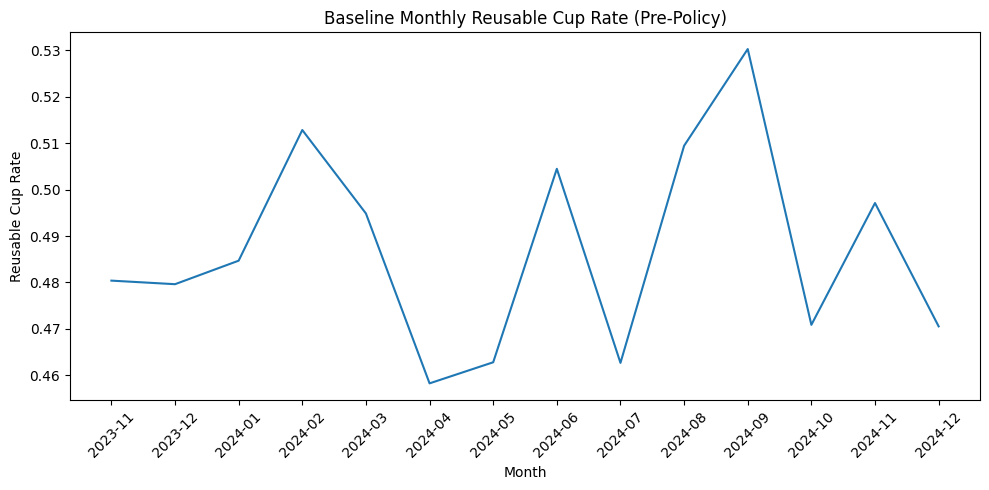

In [45]:

plt.figure(figsize=(10,5))
plt.plot(baseline_monthly['month'], baseline_monthly['reusable_rate'])
plt.xlabel('Month')
plt.ylabel('Reusable Cup Rate')
plt.title('Baseline Monthly Reusable Cup Rate (Pre-Policy)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
